In [57]:
# import packages
import numpy as np
# import scipy.integrate as integrate
# from sympy import *
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

# import astropy.units as u
from astropy import constants as const

from scipy.interpolate import interp1d


# Computing Particle Trajectories

This notebook focuses on computing and animating the trajectories of individual particles within our two-hammer potential rather than the full solution $\delta f$. I will do this in two ways:
1. By using the analytical solution to Hamilton's equations, assuming two delta-function perturbations.
2. By numerically solving Hamilton's equations, which won't necessarily assume delta-function perturbations.

# Isothermal Slab Dynamics

First, we'll directly plot the motions of individual stars within a two-hammer, isothermal slab potential. The analytical (dimensionless) solutions to Hamilton's equations are:

$$ \theta(\tilde{t}) = \theta_0 + \int_0^{\tilde{t}} d\tilde{t}' \Omega(\tilde{J}(\tilde{t}')) $$
   $$ \tilde{J}(\tilde{t}) = \tilde{J}_0 + n_1 \tilde{A}_1 \sin(n_1\theta(\tilde{t}_1)) H(\tilde{t}-\tilde{t}_1) + n_2 \tilde{A}_2 \sin(n_2 \theta(\tilde{t}_2)) H(\tilde{t}-\tilde{t}_2) $$
   
where $\tilde{\Omega}$ is:

$$ \tilde{\Omega}(\tilde{J}) = \frac{1}{\sqrt{2}} \left[1+\frac{3\sqrt{2}}{\pi^2}\tilde{J}\right]^{-1/3}. $$

## Drawing from an arbitrary random distribution

Source: https://stackoverflow.com/a/64288861

In [73]:
def inverse_sample_decorator(dist):
    
    # for now, set our maximum J to 50
    def wrapper(pnts, x_min=0, x_max=20, n=1e5, **kwargs):
        
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        cumulative -= cumulative.min()
        f = interp1d(cumulative/cumulative.max(), x)
        return f(np.random.random(pnts))
    
    return wrapper

# example distribution
# @inverse_sample_decorator
# def gauss(x, amp=1.0, mean=0.0, std=0.2):
#     return amp*np.exp(-(x-mean)**2/std**2/2.0)

In [59]:
## define the slab Omega, Hamiltonian, and f0(J)

def compute_Omega(J):
    '''
    Represents (dimensionless) Omega(J). We use Omega = a/(1 + b*J)^(1/3)
    
    '''
    
    a = 1. / np.sqrt(2)
    b = 3 * np.sqrt(2) / pow(np.pi,2)

    return a * pow(1 + b*J, -1/3)

def Hamiltonian(J):
    '''
    Computes the Hamiltonian of our system by integrating Omega(J)
    from 0 to J. (Underneath Eq. 8 in Scott's paper, it's stated that
    Omega = dH/dJ.) We assume that Omega=0 for H=0.
    
    We use Omega = a/(1 + b*J)^(1/3) and its analytical antiderivative.
    
    '''
    
    term1 = np.pi**2 / 4
    b = 3*np.sqrt(2) / (np.pi**2)
    
    term2 = (1 + b*J)**(2/3)
    return term1 * term2


def f_0(J): 
    '''
    Initial distribution function of our system, using Eq. 6 of Scott's
    paper.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

@inverse_sample_decorator
def f_0_distro(J): 
    '''
    The version of f_0(J) we use to perform inverse transform sampling.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

## Outline

Let N be the number of particles I'm simulating. (I should test N=1, 10, 100, ...). Our plan is:

1. Keep two N-length arrays, one representing the $\theta$'s of all the particles and one representing all the $J$'s at a certain timepoint $t_i$.
2. Keep an array with timepoints, e.g., `ts = np.arange(0, 300, 0.5)`.
3. Set the initial conditions. Each $J_0$ should be in $(0, 20)$, while each $\theta_0$ should be in $[0, 2\pi)$.
4. Update $\theta$ at every timestep. Update $J$ and $\Omega(J)$ iff there's a hammer.

In [98]:
## define hammer params, phase space range

# define the parameters of the two hammers (t_i, n_i, A_i)
t1, t2 = 0, 100
n1, n2 = 1, 3
A1, A2 = 0.1, 0.2

# define ts, thetas, and Js; and, corresponding Cartesian coords
N = 1 # number of particles

# time range
tmin = 0
tmax = 300
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

theta_min = 0
theta_max = 2*np.pi
thetas = np.empty(N)

J_min = 0
J_max = 20


In [99]:
np.random.seed(2)

thetas = (2*np.pi)*np.random.rand(N)
Js = f_0_distro(N) # drawn from f_0(J)

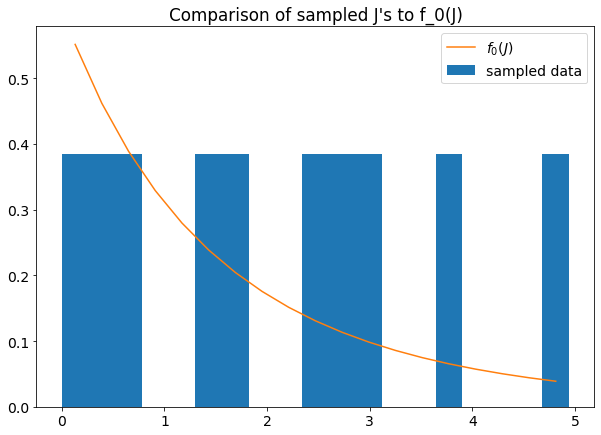

In [89]:
## check that sampling method is consistent with underlying distro

Js_temp = np.arange(0, 20, 1e-2)

# sampled J's
num_bins = 20
bins = np.linspace(0, np.max(Js), num=num_bins)
hist = plt.hist(Js, bins=bins, label="sampled data", density=True)

## distribution function
J_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
f0_temp = f_0(J_axis)

plt.plot(J_axis, f0_temp / .056, label="$f_0(J)$")

plt.title("Comparison of sampled J's to f_0(J)")
plt.legend()
plt.show()

# Animation